**1 Project Scope**

In this project convolutional neural networks were used to predict wheter a patient has no illness, COVID or pneumonia based on their x-ray lung scan. The hyperparameters of the model were then tuned to see how the accuracy of the model could be improved

    Steps:
    1) Import packages
    2) Load in data
    3) Build architecture of neural network
    4) Train neural network
    5) Visualise metrics of the model during training
    6) Tune hyperparameters of model
    7) Classification report
    8) Confusion matrix
    9) Conclusions
    10) Further work

**2 Import packages**

In [214]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras import layers


from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**3 Load in data**

ImageDataGenerator object to preprocess images (including some data augmentation to generate more data as the dataset is quite small)

In [215]:
data_generator = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, rotation_range=15, width_shift_range=0.05, height_shift_range=0.05) #normalise the data and perform data augmentation

In [216]:
batch_size = 5

Training iterator with training images

In [217]:
training_iterator = data_generator.flow_from_directory('Covid19-dataset/train', class_mode='categorical', color_mode='grayscale', target_size=(256,256), batch_size=batch_size)

Found 251 images belonging to 3 classes.


Test iterator with test images

In [218]:
test_iterator = data_generator.flow_from_directory('Covid19-dataset/test', class_mode='categorical', color_mode='grayscale', target_size=(256,256), batch_size=batch_size)

Found 66 images belonging to 3 classes.


**4 Building model**

**4.1 Building the architecture of the neural network**

In [219]:
model = Sequential() # Model object

model.add(layers.Input(shape=(256, 256, 1))) # Input layer -> each image is a 256x256 pixel image and it is grayscale so there is 1 channel

model.add(layers.Conv2D(8, 5, padding='valid', strides=2, activation='relu')) # First convolutional layer -> five 5x5 filters, valid padding, strides of 2, relu activation function to introduce non-linearity

model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # Max pooling layer for the first intermediate convolutional layer -> 5x5 filter, strides of 5 and valid padding

model.add(layers.Conv2D(8, 3, padding='valid', strides=2, activation='relu')) # third convolutional layer -> three 3x3 filters, valid padding, strides of 2, relu activation function to introduction non-linearity

model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # Max pooling layer for the third intermediate convolutional layer -> 3x3 filter, strides of 3 and valid padding

model.add(layers.Flatten()) # Flatten the output from the convolutional layers before the dense layers because the dense layers apply its matrix to the output, so the input to the dense layers needs to be the correct shape

model.add(Dense(3, activation='softmax')) # Output layer -> there are 3 classes so need 3 neurons and use softmax activation to base prediction of probabilities of each class

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = 'adam', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()]) # Compile the model with a optimizer -> as the categories are one-hot encoded Categorical cross entropy is used as the loss metric

model.summary() # summary of model

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 126, 126, 8)       208       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 31, 31, 8)         584       
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1800)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 5403      
Total params: 6,195
Trainable params: 6,195
Non-trainable params: 0
___________________________________________________

**4.2 Early stopping object** - Early stopping introduced to decrease computational requirements due to the epochs stopping when categorical accuracy plateaus 

In [220]:
es = EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=1, patience=8) # to find when the categorical accuracy is at a max

**4.3 History object for later visualisation**

In [221]:
history = History() # history object to put into the algorithm so that the metrics of the training can be remembered and later plotted

**5 Training the model**

In [222]:
model.fit(training_iterator, 
          steps_per_epoch = training_iterator.samples/batch_size, 
          epochs=30, validation_data=test_iterator, 
          validation_steps=test_iterator.samples/batch_size, callbacks=[es, history]) # fitting data to the model -> initially using 8 epochs and steps in epochs of number of samples divided by batch size, using test data for validation

# val_categorical_accuracy = validation categorical accuracy

Epoch 1/30
51/50 [==============================] - 5s 90ms/step - loss: 1.0707 - categorical_accuracy: 0.4382 - auc_44: 0.6072 - val_loss: 1.0074 - val_categorical_accuracy: 0.4545 - val_auc_44: 0.7223
Epoch 2/30
51/50 [==============================] - 4s 82ms/step - loss: 0.8670 - categorical_accuracy: 0.5976 - auc_44: 0.7938 - val_loss: 0.8328 - val_categorical_accuracy: 0.6364 - val_auc_44: 0.8005
Epoch 3/30
51/50 [==============================] - 2s 43ms/step - loss: 0.5201 - categorical_accuracy: 0.7849 - auc_44: 0.9283 - val_loss: 0.7908 - val_categorical_accuracy: 0.6818 - val_auc_44: 0.8603
Epoch 4/30
51/50 [==============================] - 2s 49ms/step - loss: 0.4778 - categorical_accuracy: 0.8127 - auc_44: 0.9364 - val_loss: 0.7865 - val_categorical_accuracy: 0.6818 - val_auc_44: 0.8715
Epoch 5/30
51/50 [==============================] - 2s 47ms/step - loss: 0.4395 - categorical_accuracy: 0.8327 - auc_44: 0.9472 - val_loss: 0.6508 - val_categorical_accuracy: 0.7121 - val_

**6 Visulisation of model metrics**

**6.1 Visualisation of AUC**

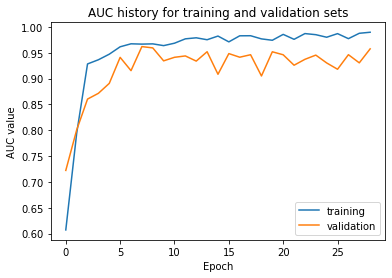

In [225]:
ax1 = plt.subplot()
ax1.plot(history.history['auc_44'])
ax1.plot(history.history['val_auc_44'])
ax1.set_title('AUC history for training and validation sets')
ax1.set_ylabel('AUC value')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'])

**6.2 Visualisation of categorical accuracy**

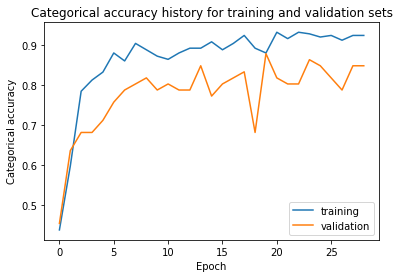

In [226]:
ax2 = plt.subplot()
ax2.plot(history.history['categorical_accuracy'])
ax2.plot(history.history['val_categorical_accuracy'])
ax2.set_title('Categorical accuracy history for training and validation sets')
ax2.set_ylabel('Categorical accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'])

**6.3 Visualisation of loss**

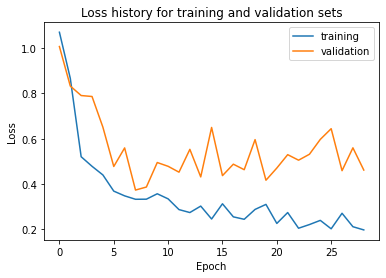

In [227]:
ax3 = plt.subplot()
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('Loss history for training and validation sets')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'])

These three graphs show that as the categorical accuracy began to plateau that the early stopping caused the algorithm to stop. However, it can be seen that the training and validation metrics are vastly different, implying that the algorithm may be overfitted to the training data.

**7 Tuning hyperparameters**

**7.1 Results of initial iteration**

Initial hyperparameters:
- Epochs = 8
- Batch size = 5 
- Number of convolutional layers = 2 -> (first = five 5x5 filters, second = three 3x3 filters)
- Number of trainable parameters = 415
- Optimizer = Adam

Results:
- Accuracy = 0.7727
- AUC = 0.9332

**7.2 Results of second iteration** - Not as good as the inital model

Initial hyperparameters:
- Epochs = 15
- Batch size = 5
- Number of convolutional layers = 2 -> (first = five 5x5 filters, second = four 4x4 filters, third = three 3x3 filters)
- Number of trainable parameters = 517
- Optimizer = Adam

Results:
- Accuracy = 0.6212
- AUC = 0.8254

**7.3 Results of third iteration** - The second convolutional layer was removed, accuracy increased, implying that the extra layer caused the model to overfit to the training data

Initial hyperparameters:
- Epochs = 15
- Batch size = 5
- Number of convolutional layers = 2 -> (first = five 5x5 filters, second = three 3x3 filters)
- Number of trainable parameters = 415
- Optimizer = Adam

Results:
- Loss = 0.3524
- Accuracy = 0.8606
- AUC = 0.9670

**7.4 Results of fourth iteration** - Categorical accuracy vastly improved due to the large increase in trainable parameters

Initial hyperparameters:
- Epochs = 15
- Batch size = 5
- Number of convolutional layers = 2 -> (first = eight 5x5 filters, second = eight 3x3 filters)
- Number of trainable parameters = 6195
- Optimizer = Adam
- Both max pooling layers with pool_size and strides of (2,2)

Results:
- Loss = 0.0580
- Accuracy = 0.9761
- AUC = 0.9993

**7.5 Results of fifth iteration** - Catergorical accuracy improved due to the increase in epoch, reaching 1.0000 at around 18 epochs, therefore the number of epochs could be decreased as to decrease computational requirements

Initial hyperparameters:
- Epochs = 25
- Batch size = 5
- Number of convolutional layers = 2 -> (first = eight 5x5 filters, second = eight 3x3 filters)
- Number of trainable parameters = 6195
- Optimizer = Adam
- Both max pooling layers with pool_size and strides of (2,2)

Results:
- Loss = 0.0023
- Accuracy = 1.0000
- AUC = 1.0000

**7.6 Results of sixth iteration** - Number of epochs were decreased to 20 to decrease computational requirements, while still acheiving the same results.

Initial hyperparameters:
- Epochs = 20
- Batch size = 5
- Number of convolutional layers = 2 -> (first = eight 5x5 filters, second = eight 3x3 filters)
- Number of trainable parameters = 6195
- Optimizer = Adam
- Both max pooling layers with pool_size and strides of (2,2)

Results:
- Loss = 0.0023
- Accuracy = 1.0000
- AUC = 1.0000

**7.7 Results of seventh iteration - Including data augmentation** - Early stopping was introduced as to decrease computational requirements (with a patience of 4) - Accuracy decreased and loss increased, meaning that the algorithm was not as accurate in this iteration. However, this could be due to the data augmentation that was implemented, which would benefit future predictions, implying that this algorithm may be more accurate for future predictions.

Initial hyperparameters:
- Epochs = 30
- Batch size = 5
- Number of convolutional layers = 2 -> (first = eight 5x5 filters, second = eight 3x3 filters)
- Number of trainable parameters = 6195
- Optimizer = Adam
- Both max pooling layers with pool_size and strides of (2,2)

Results:
- Loss = 0.1986
- Accuracy = 0.9203
- AUC = 0.9891

It was decided that the seventh iteration of the model was the best model to be used for further prediction, due to the data augmentation meaning that future predictions would be more accurate that the other iterations without data augmentation and early stopping being introduced to decrease computational requirements. Furthermore, the accuracy of this algorithm was also quite good even though the data had been augmented. Therefore, this model was used for all further work in the project.

**8 Evaluating neural network - classification report**

In [228]:
test_steps_per_epoch = np.math.ceil(test_iterator.samples/batch_size) # Finding number of steps per epoch and rounding it up

predictions = model.predict(test_iterator, steps=test_steps_per_epoch) # Predicting classes for validation data

predicted_classes = np.argmax(predictions, axis=1) # Finding the max values in the predictions option and assigning it the the value of the column index

true_classes = test_iterator.classes # True values for each picture in validation data

class_labels = list(test_iterator.class_indices.keys()) # class labels ['Covid', 'Normal', 'Pneumonia']

report = classification_report(true_classes, predicted_classes, target_names=class_labels) # Classification report display precision, recall, f1-score and support for each different class predictions

print(report)

              precision    recall  f1-score   support

       Covid       0.35      0.35      0.35        26
      Normal       0.28      0.25      0.26        20
   Pneumonia       0.27      0.30      0.29        20

    accuracy                           0.30        66
   macro avg       0.30      0.30      0.30        66
weighted avg       0.30      0.30      0.30        66



The classification report showed that the model was best at predicting COVID patients and worst for patients with no illness. However, the accuracy was not great for any class, as you would expect to get a 1/3 of classes right from random guesses.

**9 Evaluating neural network - confusion matrix**

[Text(0.5, 0, 'Covid'), Text(1.5, 0, 'Normal'), Text(2.5, 0, 'Pneumonia')]

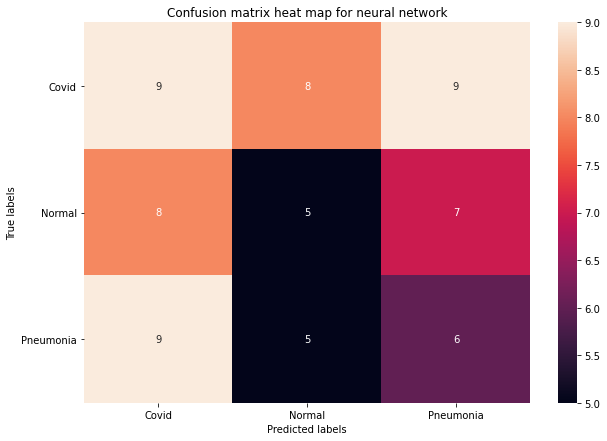

In [229]:
confusion_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,7)) # Creating a figure with a size of 10x7

ax4 = plt.subplot() # Creating an axis object with the subplot axes

sns.heatmap(confusion_matrix, annot=True, ax=ax4, fmt='d') # Creating a heat map using the confusion matrix - 'annot=True' = annotate the heat map with class labels, 'ax=ax' = uses the created axes object, 'fmt='d'' = formatting the annotations

ax4.set_xlabel('Predicted labels')
ax4.set_ylabel('True labels')
ax4.set_title('Confusion matrix heat map for neural network')

ax4.yaxis.set_tick_params(rotation=360) # Rotating y axis labels so that they don't overlap

ax4.set_yticklabels(class_labels)
ax4.set_xticklabels(class_labels)

The heatmap showed that the predictions were not great, due to many of the predictions being incorrect. This shows that the model could be improved so that the predictions were more accurate, through further tuning of the model's hyperparameters.

**10 Conclusion**

In conclusion:
- A convolutional neural network was constructed to predict whether someone has no illness, COVID or pneumonia based on their x-ray lung scan.
- The hyperparameters of the neural network then tuned to find the neural network with the highest accuracy. It was found that the seventh iteration of the neural network was the best model. This was because it gave good accuracy and loss as well as accounting for data augmentation to increase the accuracy of future predictions. This model was found to have an accuracy of 0.9203. 
- A classification report and confusion matrix heat map of this model were then constructed, from which is was found that the model was not very accurate and further hyperparameter tuning could be needed.

**11 Further work**

The project could be improved by the following:
- Hyperparameters could be further tuned to find a more accurate model, which would lead to more accurate further predictions of whether someone has no illness, COVID or pneumonia.